# Support Vector Machines 2
---

__This Notebook__

- Implement __GridSearchSV__ on `sklearn.svm.SVC` using default `kernel='rbf'`
- Set `C` and `gamma` exponentially far apart to choose good values

__Results__ 


__Next up__

- Try *string subsequence kernel* or *Levehnstein distance* kernels

## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-02


## Load

In [2]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X_tfidf_svd800_spamcos = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Helpful Functions


In [3]:
# train classifier and time it
def time_deco(func):
    def wrapper(clf):
        start = time.time()
        func(clf)
        m,s = divmod(time.time() - start, 60)
        print(f'Elapsed: {m:0.0f}m {s:0.0f}s')
    return wrapper

@time_deco
def fit_clf(clf):
    clf.fit(X_train, y_train)
    
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

##  SVC (Support Vector Classifier) 

[See docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

__Some defaults:__
- `C=1.0`: no regularization
- `kernel='rbf'`: radial basis function kernel
- `degree=3`: polynomial degree, ignored for kernels other than `poly`; also try `sigmoid` or `precomputed`?
- `gamma='scale'`: coefficient for `rbf`, `poly` and `sigmoid`
- `coef0=0.0`: independent term in kernel function. It is only significant in `poly` and `sigmoid`
- `shrinking=True`: whether to use the shrinking heuristic. 
- `probability=False`: whether to enable probability estimates. This must be enabled prior to calling fit, will slow down that method as it internally uses 5-fold cross-validation, and `predict_proba` may be inconsistent with `predict`
- `class_weight=None`: pass a dict or 'balanced' 

__Some methods:__

- `.get_params`: returns the parameters
- `.decision_function`: evaluates the decision function for the samples in X, if binary from -1 to 1
- `.predict`: performs the classification, equivalent to decision_function with a 0 threshold
- `.predict_proba`: compute probabilities of possible outcomes for samples in X. The model need to have probability information computed at training time (i.e., fit with `probability=True`)


### RBF kernel `C` and `gamma`:

[See Docs](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: $C$ and $\gamma$. Both act as regularization parameters, and one increases them to avoid underfitting, and decreases them to avoid overfitting.

$C$: common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low $C$ makes the decision surface smooth, while a high $C$ aims at classifying all training examples correctly. 

$\gamma$: defines how much influence a single training example has. Increasing $\gamma$ makes the bell-shape curve narrower so the closer other examples must be to be affected, this means each instance's range of influence is smaller and the decision boundary is more irregular, wiggling around individual instances.

In [5]:
# instantiate with defaults
rbf_kernel_svm_clf =  SVC(kernel="rbf", 
                          gamma="scale",
                          C=1.0,
                          random_state=42)

In [6]:
# train
fit_clf(rbf_kernel_svm_clf)

Elapsed: 0m 18s


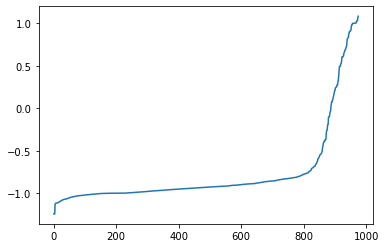

In [7]:
# evaluate using decision function
y_score = rbf_kernel_svm_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

Predicting with `threshold=0` is equivalent to using the `.predict` method

In [8]:
# default threshold
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        41        88
acc: 0.9579
tpr: 0.6822
tnr: 1.0000


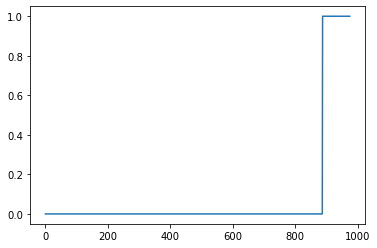

In [9]:
y_pred = rbf_kernel_svm_clf.predict(X_val)
plt.plot(sorted(y_pred))
plt.show()

In [10]:
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        41        88
acc: 0.9579
tpr: 0.6822
tnr: 1.0000


## GridSearchCV

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score

def gridsearch_wrapper(X, y, param_grid, k=5, n_jobs=6):
    """
    Performs a grid search with
    Args:
        X: numeric matrix
        y: target variable
        k: number of CV folds
        n_jobs: number of logical cores
    """
    start_time = time.time()

    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      stratify=y,
                                                      random_state=42)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
        'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
    }

    # instantiate estimator
    clf = SVC(kernel='rbf', random_state=42)

    # instantiate k-fold gridsearch
    cv_folds = StratifiedKFold(n_splits=k)
    
    grid_search_clf = GridSearchCV(clf, 
                                   param_grid,
                                   scoring=scorers, 
                                   refit='tpr', 
                                   cv=cv_folds, 
                                   return_train_score=True, 
                                   n_jobs=n_jobs,
                                   verbose=1)
    
    # train models
    grid_search_clf.fit(X_train, y_train)

    # predict
    y_pred = grid_search_clf.predict(X_val)
    print(f'Best params: {grid_search_clf.best_params_}')

    # eval metrics
    print('Evaluation metrics:')
    eval_clf(y_val, y_pred)
    
    return grid_search_clf

In [30]:
params = {
    'gamma': [.001, .01, .1, 1, 10],
    'C': [.01, .1, 1, 10, 100]
}

In [33]:
grid_search_clf = gridsearch_wrapper(X_tfidf_svd800_spamcos, 
                                     y, 
                                     params, 
                                     k=5, 
                                     n_jobs=-1)

## Persist


In [34]:
# save gridsearch
save_path = os.path.join("data", "3_modeling", "02032021_svm_gridsearch.joblib")
joblib.dump(grid_search_clf, save_path)

---